# Solving PDEs with NNs

25-01-2024 (code in progress), Mike Wendels

## Case I: heat equation

Consider the IBVP:
\begin{align}
\begin{dcases}
u_t = 0.5 u_{xx} \\
u(0,t) = s u(1,t) \\
u_x(0,t) = u_x(1,t) \\
u(x,0) = \eta(x)
\end{dcases}
\end{align}
with $s \neq 1$.

In [3]:
# download some packages
import sys
print(sys.executable)
!/opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install numpy
!/opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install matplotlib
!/opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install torch torchvision torchaudio


/opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.0/libexec/bin/python -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## input

xstart,xend,dx = 0,1,0.001
tstart,tend,dt = 0,0.1,0.0001
s = 2.0
eta = lambda x : np.exp(-20*np.power(x-0.5,2)) #initial condtion e^(-20*(x-0.5)^2)

In [35]:
## solver

def diagM(val,dim,diag=0):
    return np.diag([val for i in range(dim-int(np.abs(diag)))], k=diag)

xgrid = np.arange(xstart,xend+dx,dx)
nx = int((xend-xstart)/dx)+1 # number of exterior points
# one point on the boundry?
mx = nx - 2 # number of interior grid points

# construct matrix Br for time iterations
B = np.zeros((mx,mx), dtype = float) # to get an array with floats instead of integers
B += diagM(-2,mx,diag=0) + diagM(1,mx,diag=1) + diagM(1,mx,diag=-1) # construct tri-diagonal matrix
B[0,0] += s/(1+s)
B[mx-1,mx-1] += 1/(1+s)
A = np.zeros((mx,mx))
A[0,mx-1] = s/(1+s)
A[mx-1,0] = 1/(1+s) #why set like that

B = B + A
print(B)

r = dt/(2*dx**2)
Br = diagM(1,mx) - r*B


# time-integration
tgrid = np.arange(tstart,tend+dt,dt)
nt = int((tend-tstart)/dt) # number of time steps, not number of time points!

U = np.zeros((nx,nt+1)) # initial condition also added
for i in range(1,nx):
    U[i,0] = eta(xgrid[i])
for k in range(nt):
    if k%10 == 0:
        print("time iteration "+str(k))
    Unew = np.linalg.solve(Br,U[1:nx-1,k]) # solve the Br * x = U
    U[1:nx-1,k+1] = Unew
    U[nx-1,k+1] = (Unew[0]+Unew[-1])/(1+s)
    U[0,k+1] = s*U[nx-1,k+1]
#Store each time step solution in the matrix U ?
print(U)

[[-1.33333333  1.          0.         ...  0.          0.
   0.66666667]
 [ 1.         -2.          1.         ...  0.          0.
   0.        ]
 [ 0.          1.         -2.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -2.          1.
   0.        ]
 [ 0.          0.          0.         ...  1.         -2.
   1.        ]
 [ 0.33333333  0.          0.         ...  0.          1.
  -1.66666667]]
time iteration 0
time iteration 10
time iteration 20
time iteration 30
time iteration 40
time iteration 50
time iteration 60
time iteration 70
time iteration 80
time iteration 90
time iteration 100
time iteration 110
time iteration 120
time iteration 130
time iteration 140
time iteration 150
time iteration 160
time iteration 170
time iteration 180
time iteration 190
time iteration 200
time iteration 210
time iteration 220
time iteration 230
time iteration 240
time iteration 250
time iteration 260
time iteration 270
time iteration 280
time iteration 2

[0.    0.001 0.002 ... 0.998 0.999 1.   ]
[0.43852209 0.43808204 0.43764553 ... 0.22014291 0.21970109 0.21926104]


Text(0, 0.5, 'u')

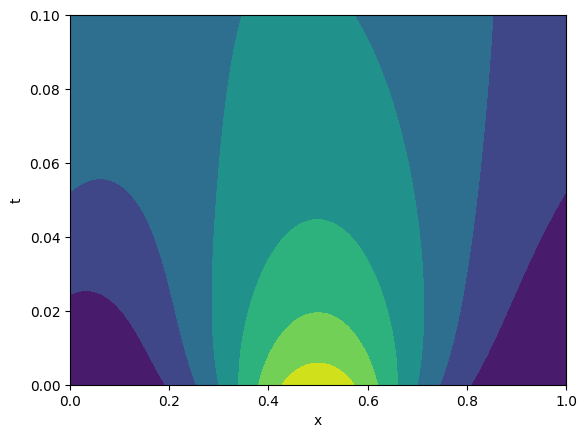

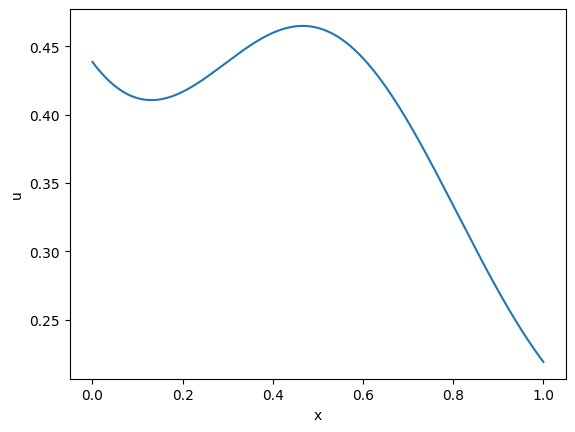

In [36]:
plt.figure(1)
plt.contourf(xgrid,tgrid,np.transpose(U))
plt.xlabel("x")
plt.ylabel("t")

plt.figure(2)
plt.plot(xgrid,U[:,-1])
print(xgrid)
print(U[:,-1])
plt.xlabel("x")
plt.ylabel("u")

## Neural network training

In [5]:
import torch
import torch.nn as nn
torch.manual_seed(42)

In [45]:
# input

# input sampling
n_i = 1000 # number of points in interior
n_xstart = 200 # number of points on xstart boundary
n_xend = 200 # number of points on xend boundary
n_tstart = 400 # number of points on tstart boundary
n_tend = 0 # number of points on tend boundary

# hyperparameters
ftrain = 0.8
fval = 0
ftest = 1 - ftrain - fval

lr = 0.01
num_epochs = 100


tensor([[0.8694, 0.0929],
        [0.2906, 0.0120],
        [0.0297, 0.0709],
        ...,
        [0.3164, 0.0179],
        [0.4834, 0.0000],
        [0.5981, 0.0193]])


Text(0, 0.5, '$t$')

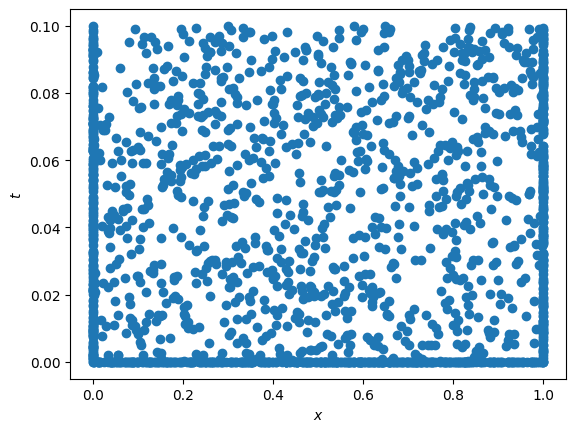

In [46]:
## sampling training points (x,t) - random approach

n = n_i + n_xstart + n_xend + n_tstart + n_tend
X = (xstart + (xend-xstart)*torch.rand(n)).view(-1, 1)# .view(-1,1) is the transpose in this case to make every element a separate array/data point
T = (tstart + (tend-tstart)*torch.rand(n)).view(-1, 1)
X[n_i:n_i+n_xstart] = xstart
X[n_i+n_xstart:n_i+n_xstart+n_xend] = xend
T[n_i+n_xstart+n_xend:n_i+n_xstart+n_xend+n_tstart] = tstart
T[n_i+n_xstart+n_xend+n_tstart:n_i+n_xstart+n_xend+n_tstart+n_tend] = tend

XT = torch.zeros(n,2)
XT[:,0] = X.reshape(n)
XT[:,1] = T.reshape(n)
XT = torch.tensor(np.random.permutation(XT)) # to randomly permute the data points
print(XT)

plt.figure()
plt.scatter(X,T)
plt.xlabel("$x$")
plt.ylabel("$t$")

In [51]:
# neural network
class NNheat(nn.Module):
    def __init__(self):
        super(NNheat, self).__init__()
        self.layer1 = nn.Linear(2, 100)  # Input size is 2 for a 2-dimensional input vector
        self.hidden = nn.Linear(100, 100)
        self.layer2 = nn.Linear(100, 1)  # Output size is 2 for a 2-dimensional output vector

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        for i in range(8):
            x = torch.tanh(self.hidden(x))
        x = self.layer2(x)
        return x
    
model = NNheat()


# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def criterion(XT,UV,nnet,lnorm=2):
    loss = 0
    ninput = np.array(XT).shape[0]
    for i in range(ninput):

        XTi = XT[i]
        UVi = UV[i]

        if XTi[1] == tstart:
            loss += torch.linalg.norm(UVi - eta(XTi[0]),lnorm)

        elif XTi[0] == xstart:
            XTi_ref = torch.tensor([xend,XTi[1]])
            UVi_ref = nnet(XTi_ref)
            u_x = torch.autograd.functional.jacobian(nnet, XTi)[0]
            u_x_ref = torch.autograd.functional.jacobian(nnet, XTi_ref)[0]
            loss += torch.linalg.norm(UVi - s*UVi_ref, lnorm) + torch.linalg.norm(u_x - u_x_ref, lnorm)

        elif XTi[0] == xend:
            XTi_ref = torch.tensor([xstart,XTi[1]])
            UVi_ref = nnet(XTi_ref)
            u_x = torch.autograd.functional.jacobian(nnet, XTi)[0]
            u_x_ref = torch.autograd.functional.jacobian(nnet, XTi_ref)[0]
            loss += torch.linalg.norm(UVi - s*UVi_ref, lnorm) + torch.linalg.norm(u_x - u_x_ref, lnorm)

        else:
            J = torch.autograd.functional.jacobian(nnet, XTi)
            H = torch.autograd.functional.hessian(nnet, XTi)
            u_xx = H[0][0]
            u_t = J[0][1]
            loss += np.linalg.norm(u_t - 0.5*u_xx)

        # a = torch.tensor(0.).to(XT.device)
        # for j in nnet.parameters():
        #     a += torch.norm(param)

        # loss += lambda_reg * a

    return loss


# training
ntrain = int(ftrain*n)
for epoch in range(num_epochs):

    U = model(XT[:ntrain])
    loss = criterion(XT[:ntrain],U,model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 138.3339
Epoch [10/100], Loss: 199.8224
Epoch [20/100], Loss: 372.4521
Epoch [30/100], Loss: 293.5601
Epoch [40/100], Loss: 211.1049
Epoch [50/100], Loss: 212.9552
Epoch [60/100], Loss: 245.8224
Epoch [70/100], Loss: 297.3277
Epoch [80/100], Loss: 144.4650
Epoch [90/100], Loss: 155.1532
Epoch [100/100], Loss: 176.3546
